In [1]:
import warnings
warnings.filterwarnings('ignore')
from dotenv import load_dotenv
import os

# Cargar las variables de entorno desde el archivo .env
load_dotenv()

True

In [2]:
import mlflow
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
import xgboost as xgb

In [3]:
try:
    # Intentar leer el archivo localmente
    data = pd.read_csv('../data/Steel_industry_data.csv')
except FileNotFoundError:
    # Si no se encuentra, leer desde la URL
    data = pd.read_csv('https://raw.githubusercontent.com/luis-huacho/INF648-Proy-Curso-2024-01/main/data/Steel_industry_data.csv')

# Seleccionar las columnas para la regresión
features = data.drop(columns=['date', 'Usage_kWh'])
target = data['Usage_kWh']

param_grid = {
    'regressor__n_estimators': [100, 200, 300, 500, 700],
    'regressor__max_depth': [3, 5, 7, 10],
    'regressor__learning_rate': [0.01, 0.1, 0.2, 0.3],
    'regressor__subsample': [0.6, 0.8, 1.0],
    'regressor__colsample_bytree': [0.6, 0.8, 1.0],
    'regressor__gamma': [0, 0.1, 0.2, 0.3],
    'regressor__reg_alpha': [0, 0.1, 0.5, 1],
    'regressor__reg_lambda': [0, 0.1, 0.5, 1]
}

# Obtener la URI de seguimiento de MLflow
mlflow_tracking_uri = os.getenv("MLFLOW_TRACKING_URI")

if not mlflow_tracking_uri:
    # Preguntar al usuario por la dirección si no se encuentra la variable de entorno
    mlflow_tracking_uri = input("Ingrese la dirección de MLflow: ")

# Configurar la URI de seguimiento de MLflow
mlflow.set_tracking_uri(mlflow_tracking_uri)

# Nombre del experimento
experiment_name = "XGBoost|RandomizedSearchCV"

# Crear un experimento de MLflow
experiment_id = mlflow.create_experiment(experiment_name) if not mlflow.get_experiment_by_name(experiment_name) else mlflow.get_experiment_by_name(experiment_name).experiment_id

# Iniciar un nuevo run de MLflow
with mlflow.start_run(experiment_id=experiment_id):
    # Codificación de variables categóricas
    categorical_features = ['WeekStatus', 'Day_of_week', 'Load_Type']
    numerical_features = features.drop(columns=categorical_features).columns.tolist()
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', 'passthrough', numerical_features),
            ('cat', OneHotEncoder(), categorical_features)
        ]
    )
    
    # Configurar el modelo
    model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('regressor', xgb.XGBRegressor(random_state=42, n_jobs=-1, verbosity=2, objective='reg:squarederror'))])
    
    # Configurar RandomizedSearchCV
    random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, scoring='neg_root_mean_squared_error', cv=3, verbose=2, n_iter=30, n_jobs=-1, random_state=42)
    
    # Dividir los datos en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
    
    # Entrenar RandomizedSearchCV
    random_search.fit(X_train, y_train)
    
    mlflow.log_metric("n_estimators",random_search.best_params_['regressor__n_estimators'])
    mlflow.log_metric("max_depth",random_search.best_params_['regressor__max_depth'])
    mlflow.log_metric("learning_rate",random_search.best_params_['regressor__learning_rate'])
    mlflow.log_metric("subsample",random_search.best_params_['regressor__subsample'])
    mlflow.log_metric("colsample_bytree",random_search.best_params_['regressor__colsample_bytree'])
    mlflow.log_metric("gamma",random_search.best_params_['regressor__gamma'])
    mlflow.log_metric("reg_alpha",random_search.best_params_['regressor__reg_alpha'])
    mlflow.log_metric("reg_lambda",random_search.best_params_['regressor__reg_lambda'])
       
    # Mostrar los mejores parámetros y el mejor score
    print(f"Best parameters: {random_search.best_params_}")
    print(f"Best score: {random_search.best_score_}")
    
    #mlflow.log_metric("params", random_search.best_params_)
    
    # Entrenar el modelo final con los mejores parámetros
    best_model = random_search.best_estimator_
    
    # Evaluar el modelo en el conjunto de prueba
    y_pred = best_model.predict(X_test)
    
    # Calcular las métricas
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Registrar los parámetros y métricas en MLFlow
    mlflow.log_metric("mse", mse)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("r2", r2)
    
    # Registrar el modelo en MLflow
    mlflow.sklearn.log_model(best_model, "model")

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best parameters: {'regressor__subsample': 0.8, 'regressor__reg_lambda': 1, 'regressor__reg_alpha': 0, 'regressor__n_estimators': 500, 'regressor__max_depth': 3, 'regressor__learning_rate': 0.3, 'regressor__gamma': 0.2, 'regressor__colsample_bytree': 1.0}
Best score: -1.0547866696887156


In [4]:
print(f'mse: {mse}')
print(f'rmse: {rmse}')
print(f'mae: {mae}')
print(f'r2: {r2}')

mse: 0.9773188894141625
rmse: 0.988594400861224
mae: 0.4959153535805609
r2: 0.9991402307697194


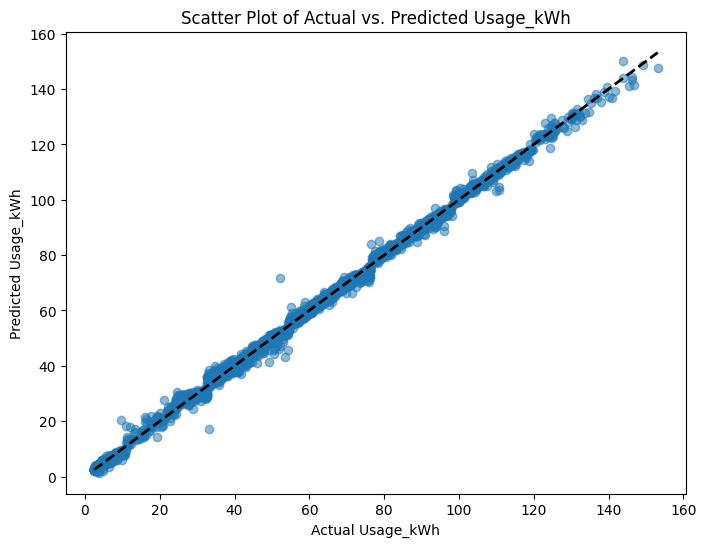

In [5]:
# Y real Vs Y pred 
plt.figure(figsize=(8, 6))
num_points = -1
plt.scatter(y_test[:num_points], y_pred[:num_points], alpha=0.5)
plt.xlabel('Actual Usage_kWh')
plt.ylabel('Predicted Usage_kWh')
plt.title('Scatter Plot of Actual vs. Predicted Usage_kWh')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.show()